In [1]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union

from langchain_openai import ChatOpenAI


# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

In [3]:
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-0125-preview', temperature=0)

# Context for FFT

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# FFT docs 
url = """https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm""" # """https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format"""# """https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html""" # 
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Add 
#docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

# Tests

## Multiple processor unconventional computer

In [14]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": """
     Our objective is to build a new kind of hardware which consists of 100 very simple processors (scaler processor), a large FIFO and a final output memory such that each processor takes a task from the FIFO,
     executes it and puts the results back into the fifo. The tasks consist of performing an operation (add, subtract, multiply or divide) and then putting the resutls in the output memory.
     each task has the following structure:
     task code (4 bits)| Data A (8 bits) | Data B (8 bits) which gives a total of 20 bits
     The coprocessor must communicate with the rest of the FPGA via axi dma and must be pynq compatible the language must be xilix HLS cpp.", #"design an 8-bit RISC V processor in system verilog""", 
     "context" : concatenated_content}
)

# FFT

In [7]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": """Build a 128 point fft circuit (named fft128) which is using two 64 point fft modules (named fft64) to compute the 128 point fft. You do not need to design the 64 point fft devices. You can assume that they just exist.
     the input to the fft module is an array of 128 double precision fixed point real numbers (such as a DSP signal measured elsewhere.) The implementation language must be system verilog. The design must be optimized for maximum performance (speed.)""", 
     "context" : concatenated_content})

## Very high precision gaussian mixture

In [15]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": """
     Your task is to build a very high precision gaussian mixuture calculator to be implemented on an ultra96-v2 board. The mixture will consist of 10 gaussians. The circuit should take a set of 10 mus, variances, weights and input x's and 
     The calculator must communicate with the rest of the FPGA via axi-dma and must be pynq compatible the language must be xilix HLS cpp. The gaussian's parameters and the input x's must use separate axi dmas and there should be a third axi-lite for the output value
     A very important part of this project is that we want to use a very accurate representation of the values. The input and output values are in float64 but the computation must be performed in quadrouple precision floating point (not the fixed point) format. You have to code this 128 bit floating point representation from scratch and code the computations based on this representation. The output must be converted and returned in float64 format""", 
     "context" : concatenated_content}
)

# Quadruple precision floating point

In [5]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": """
     Build a quadrouple precision floating point (not the fixed point) exponentiation module. You have to code this 128 bit floating point representation from scratch, using the context I provided, and code the computations based on this representation.""", 
     "context" : concatenated_content}
)

In [10]:
import pprint
pprint.pprint(requirements.goals)
#requirements.requirements = requirements.requirements[:4]
pprint.pprint(requirements.requirements)

['Design a 128-point FFT circuit using two 64-point FFT modules.',
 'Optimize the design for maximum performance in terms of speed.']
['The circuit, named fft128, must integrate two existing 64-point FFT modules '
 '(fft64) to compute the 128-point FFT.',
 'Input to the fft128 module: An array of 128 double precision fixed point '
 'real numbers.',
 'The implementation must be done in SystemVerilog.',
 'The design must leverage the Cooley–Tukey FFT algorithm, specifically the '
 'radix-2 DIT (decimation-in-time) approach for splitting the DFT into smaller '
 'DFTs.',
 'The fft128 module must handle data reordering and bit reversal as required '
 'by the radix-2 DIT algorithm.',
 'Optimize the design to minimize computation time, considering the use of '
 'parallel processing capabilities of the FPGA where applicable.',
 'Ensure the design supports double precision fixed point numbers to maintain '
 'the accuracy of the DSP signal processing.',
 'Include considerations for efficient mem

In [11]:
requirements.requirements.append("The 64-point FFT modules (fft64) do not need to be designed. You can assume that they just exist.")

# Research Agent

In [12]:
# retriever

from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import chromadb

embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
if os.path.isdir('chroma_db'):
    persistent_client = chromadb.PersistentClient(path="./knowledge_base")
    pdfsearch = Chroma(client=persistent_client, embedding_function=embeddings_3_small)
else:
    texts = []
    for item in ["https://arxiv.org/pdf/1502.07055", "https://arxiv.org/pdf/1810.06885", "https://arxiv.org/pdf/1808.02521"]: # PDF
        loader = PyPDFLoader(item, extract_images=True) #"https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"
        pages = loader.load()
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
        texts.append(text_splitter.split_documents(pages))
    pdfsearch = Chroma.from_documents(texts, embeddings_3_small, collection_name= "knowledge_base", persist_directory="./knowledge_base")

In [13]:
from FPGA_AGI.chains import WebsearchCleaner

webcleaner = WebsearchCleaner.from_llm(llm=bigllm)
cleaned_concatenated_content = webcleaner.invoke(concatenated_content)
cleaned_concatenated_content = cleaned_concatenated_content.cleaned
pprint.pprint(cleaned_concatenated_content)

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point unit consisting of basic arithmatic and extra exponentiation operation (not common in FPUs).', 'Code the 128-bit floating point representation from scratch.', 'Ensure the module computes exponentiation based on the custom 128-bit floating point representation.']\n                    requirements:\n                    ['The module must support a 128-bit floating point format, adhering to the IEEE 754 standard for quadruple precision, which includes a 1-bit sign, a 15-bit exponent, and a 113-bit significand (112 bits explicitly stored, with one bit implicit).', 'Implement exponent encoding using an offset binary representation, with an exponent bias of 16383.', 'Handle special cases as per IEEE 754 standa

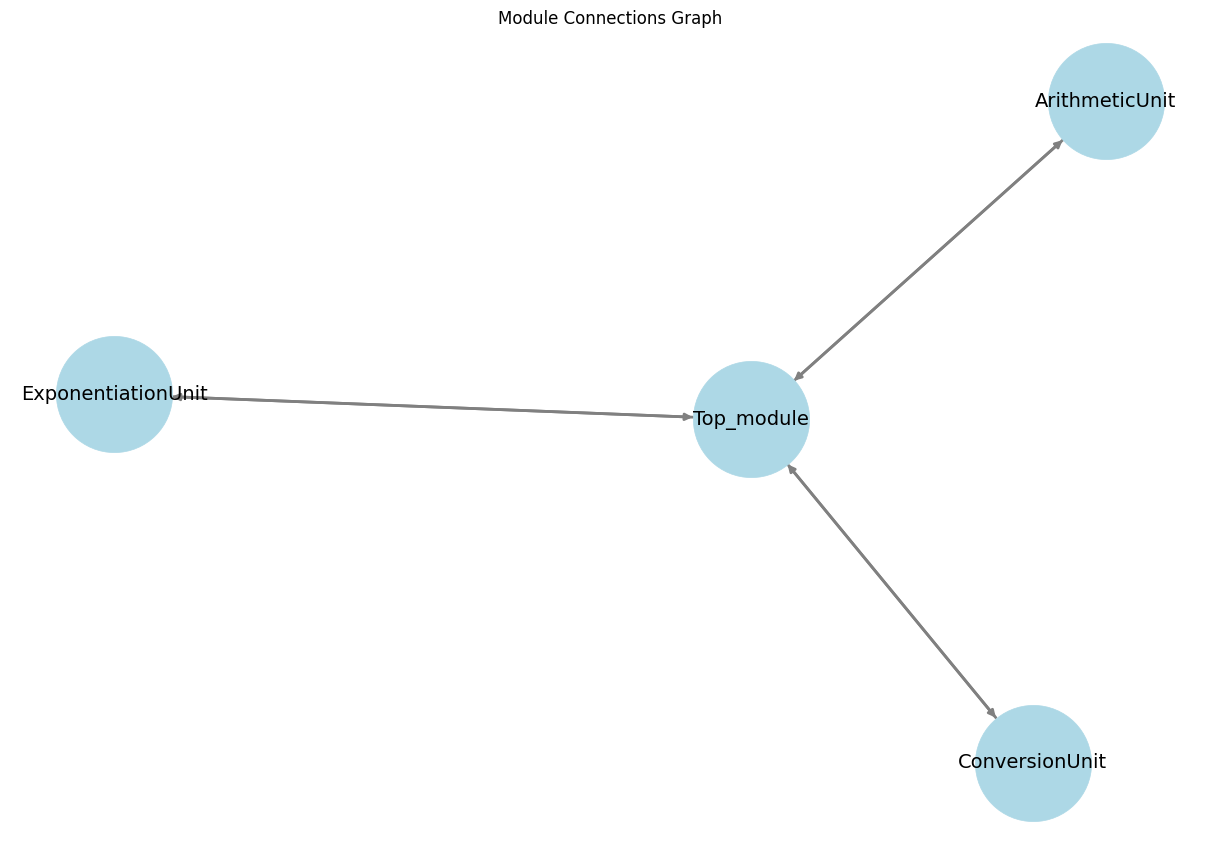

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point unit consisting of basic arithmatic and extra exponentiation operation (not common in FPUs).', 'Code the 128-bit floating point representation from scratch.', 'Ensure the module computes exponentiation based on the custom 128-bit floating point representation.']\n                    requirements:\n                    ['The module must support a 128-bit floating point format, adhering to the IEEE 754 standard for quadruple precision, which includes a 1-bit sign, a 15-bit exponent, and a 113-bit significand (112 bits explicitly stored, with one bit implicit).', 'Implement exponent encoding using an offset binary representation, with an exponent bias of 16383.', 'Handle special cases as per IEEE 754 standa

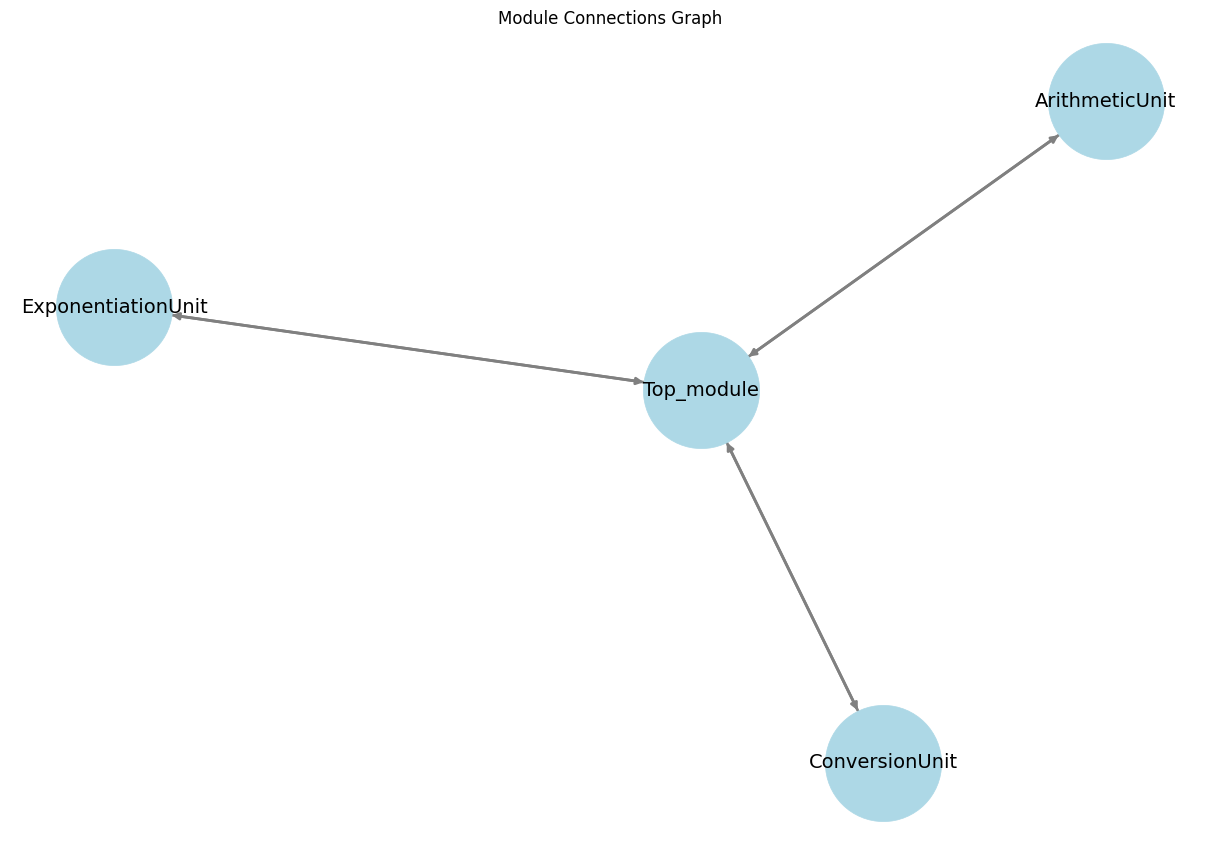

---QUESTION GENERATION---
[HumanMessage(content="Design the literature review set of questions for the following goals and requirements. Be considerate of the user input context.\n                    goals:\n                    ['Design and implement a quadruple precision floating point unit consisting of basic arithmatic and extra exponentiation operation (not common in FPUs).', 'Code the 128-bit floating point representation from scratch.', 'Ensure the module computes exponentiation based on the custom 128-bit floating point representation.']\n                    requirements:\n                    ['The module must support a 128-bit floating point format, adhering to the IEEE 754 standard for quadruple precision, which includes a 1-bit sign, a 15-bit exponent, and a 113-bit significand (112 bits explicitly stored, with one bit implicit).', 'Implement exponent encoding using an offset binary representation, with an exponent bias of 16383.', 'Handle special cases as per IEEE 754 standa

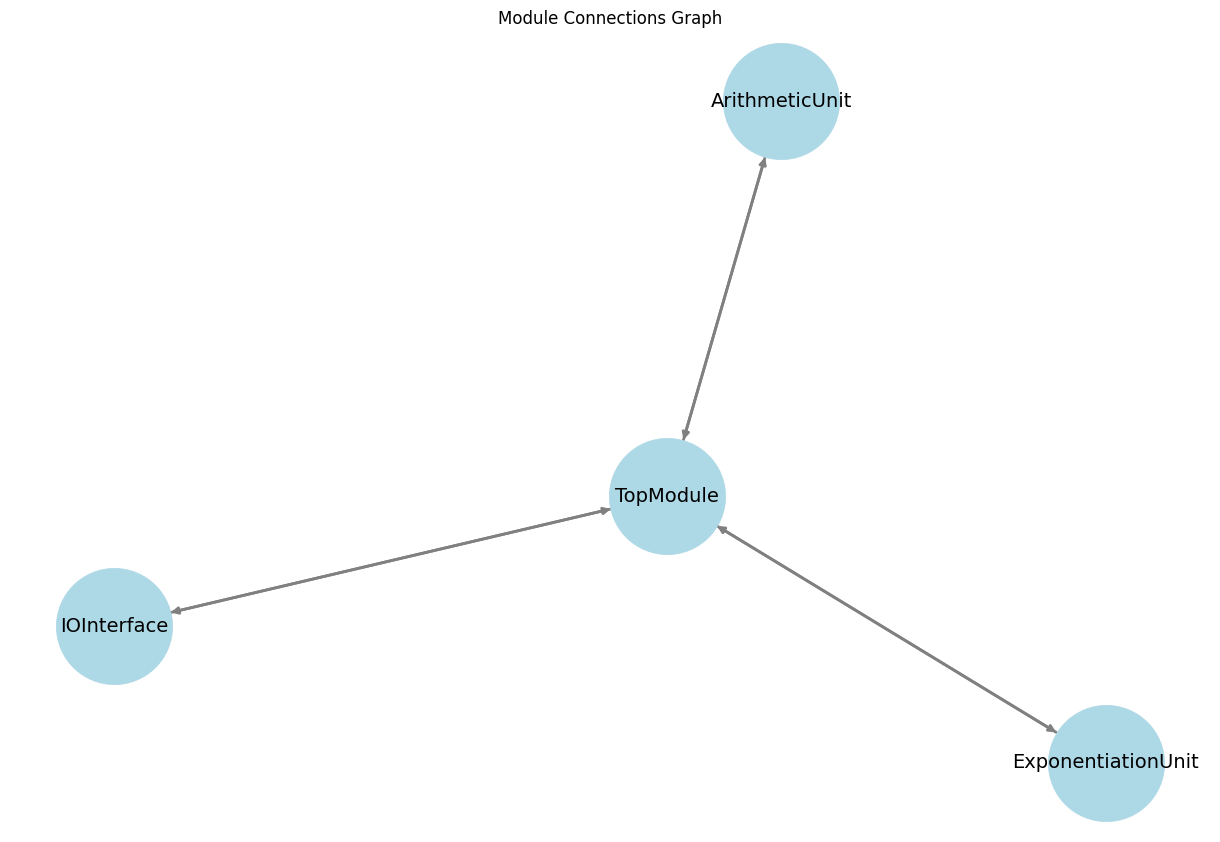

In [61]:
import importlib
from FPGA_AGI import tools
importlib.reload(tools)
from FPGA_AGI import parameters
importlib.reload(parameters)
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI import prompts
importlib.reload(prompts)
from FPGA_AGI import chains
importlib.reload(chains)
from langchain_core.prompts import HumanMessagePromptTemplate
from FPGA_AGI import agents
importlib.reload(agents)
from FPGA_AGI.agents import Engineer
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI.utils import plot_graph

bigllm = ChatOpenAI(model='gpt-4-turbo', temperature=0)
for i in range(3):
    sol_dir = f'FFT_SystemVerilog_{i}'
    R = Engineer(model=bigllm, retriever=pdfsearch.as_retriever(search_kwargs={"k": 1}), language="SystemVerilog", solution_num=sol_dir)
    #try:
    R.invoke(goals=requirements.goals, requirements=requirements.requirements, input_context= cleaned_concatenated_content)
    with open(f"solution_{sol_dir}/requirements.txt", "w") as file:
        file.write("Goals: \n" + '\n'.join(requirements.goals) + "\nRequirements: \n" + '\n'.join(requirements.requirements))
    plot_graph(R.hierarchical_solution_result, save_path=f"solution_{sol_dir}/graph.png")
    #except:
    #    pass

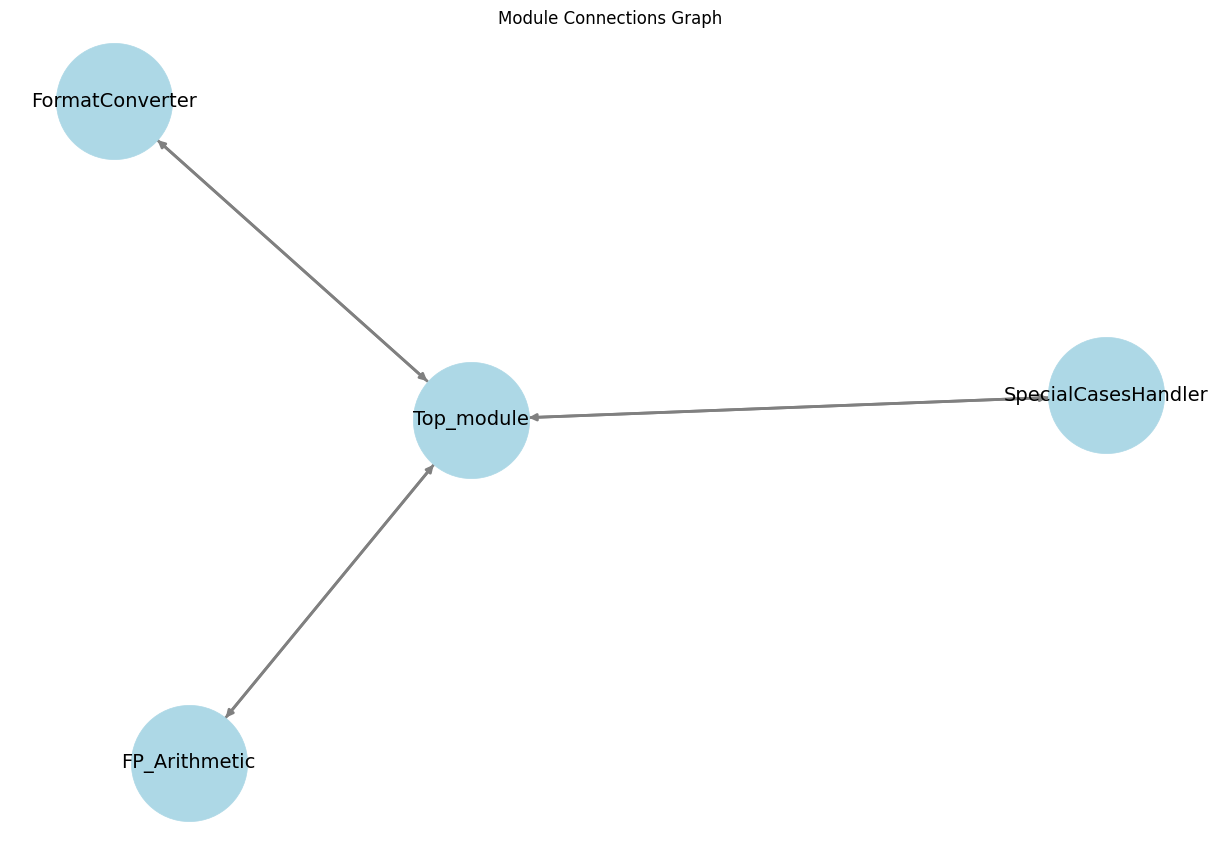

In [48]:
from FPGA_AGI import utils
importlib.reload(utils)
from FPGA_AGI.utils import plot_graph
plot_graph(R.hierarchical_solution_result)

In [38]:
type(requirements.goals)

list